# Background

In this notebook, we conduct feature engineering followed by resampling. As the fraud target statuses are categorised by clients as a whole rather than by individual invoices, we will have to summarise invoice data per client and add them to the client dataset. 

We did consider merging the client data onto the invoice data so that we may perform model building with each invoice, but we decided not to as fraudulent customers will contain a mixture of normal and fraud meter usage invoices. Having even the normal ones categorised as fraud in the invoice data might make it inaccurate for model developmentdue to its misclassifications.

For resampling, we will do oversampling via SMOTE.

# Importing Packages and Dataset

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [3]:
# Importing train datasets
client_train = pd.read_csv("finalised_datasets/cleaned_data/cleaned_client_train.csv")
invoice_train = pd.read_csv("finalised_datasets/cleaned_data/cleaned_invoice_train.csv")

display(client_train.head())
display(invoice_train.head())

,district,client_id,client_catg,region,creation_date,fraud_status
0,60,train_Client_0,11,101,1994-12-31,0.0
1,69,train_Client_1,11,107,2002-05-29,0.0
2,62,train_Client_10,11,301,1986-03-13,0.0
3,69,train_Client_100,11,105,1996-07-11,0.0
4,62,train_Client_1000,11,303,2014-10-14,0.0


,client_id,invoice_date,meter_number,meter_status,meter_code,reading_remark,meter_coefficient,consumption_level_1,consumption_level_2,consumption_level_3,consumption_level_4,old_index,months_number,meter_type,total_consumption,diff_in_index,is_index_discrepancy
0,train_Client_0,2014-03-24,1335667,0.0,203,8,1,82,0,0,0,14302,4,0,82,82,False
1,train_Client_0,2013-03-29,1335667,0.0,203,6,1,1200,184,0,0,12294,4,0,1384,1384,False
2,train_Client_0,2015-03-23,1335667,0.0,203,8,1,123,0,0,0,14624,4,0,123,123,False
3,train_Client_0,2015-07-13,1335667,0.0,207,8,1,102,0,0,0,14747,4,0,102,102,False
4,train_Client_0,2016-11-17,1335667,0.0,207,9,1,572,0,0,0,15066,12,0,572,572,False


# Feature Engineering

The key ideas behind these feature engineering steps were derived mainly from our Exploratory Data Analysis process, in outlining how to best summarise each feature for each client, to ensure that the meaning behind our features are as broad as possible why striving to minimise dimensionality.

Generally: 
- For categorical variables that contains many unique values, we extract them into the no. of unique occurences of those variables.
- We aggregate for base statistics of numerical variables per client.
- We one hot encode the remaining categorical variables. For some of these variables, we further aggregate them into the sum of each occurence per client.

For feature engineering, we defined a few key functions to perform the transformations.

1. Encode categorical variables: 
- This function encodes categorical variables and sums them up by client.
- Essentially, this will apply more to columns such as `meter_status` or `reading_remark` etc., where it represents how many invoices belong to each subcategory for that column variable.
2. Aggregate categorical variables: 
- this function determines the no. of unique occurences of `meter_number` types and `meter_code` types that each client might have.
3. Aggregate numerical variables:
- this function obtains mean, min, max, median, standard deviation and sum, of numerical variables for each client.
4. Get invoice counts:
- this function creates a column `invoice_count` that represents the total no. of invoices per client.
5. Transform datetime:
- this function creates a new column `time_since_last_invoice` to represent the time between each invoice recorded per client, aggregating them for min, max, mean, median and standard deviation.

In [3]:
# Function to encode categorical variables and aggregate the values
def encode_categorical_variables(df, columns):

    # Encoding categorical variables
    df = pd.get_dummies(df, columns=columns)

    # Group by client_id and sum the values
    df = df.groupby('client_id').sum().reset_index()

    return df

# Function to aggregate categorical variables
def aggregate_categorical_vars(df):

    # Aggregating categorical variables
    agg_categorical_invoice_train = df.groupby('client_id').agg({
        'meter_number': 'nunique',
        'meter_code': 'nunique'
    })

    agg_categorical_invoice_train.columns = ['meter_number_count', 'meter_code_count']
    agg_categorical_invoice_train.reset_index(inplace=True)

    return agg_categorical_invoice_train

# Function to aggregate numerical variables
def aggregate_numerical_vars(df):

    # Aggregating numerical variables
    agg_invoice_train = df.groupby('client_id').agg({
        'consumption_level_1': ['mean', 'std', 'min', 'max', 'median', 'sum'],
        'consumption_level_2': ['mean', 'std', 'min', 'max', 'median', 'sum'],
        'consumption_level_3': ['mean', 'std', 'min', 'max', 'median', 'sum'],
        'consumption_level_4': ['mean', 'std', 'min', 'max', 'median', 'sum'],
        'old_index': ['mean', 'std', 'min', 'max', 'median'],
        'diff_in_index': ['mean', 'std', 'min', 'max', 'median', 'sum'],
        'total_consumption': ['mean', 'std', 'min', 'max', 'median', 'sum'],
        'months_number': ['mean', 'std', 'min', 'max', 'median']
    })

    agg_invoice_train.columns = ['{}_{}'.format(col, stat) for col, stat in agg_invoice_train.columns]
    agg_invoice_train.reset_index(inplace=True)

    return agg_invoice_train

# Function to get no. of invoices per client
def get_invoice_counts(df):

    # No. of invoices per client
    invoice_count = df.groupby('client_id').size().reset_index(name='no_of_invoices')

    return invoice_count

# Function to transform datetime features with aggregation
def transform_datetime(df):

    # Transform datetime formats
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

    # Sort the invoice_train dataset by invoice_date and clients
    temp_df = df.sort_values(by=['client_id', 'invoice_date'])
    temp_df = temp_df[['client_id', 'invoice_date']]

    # Calculate the difference between the invoice dates
    temp_df['time_since_last_invoice'] = temp_df.groupby('client_id')['invoice_date'].diff().dt.days.fillna(0)

    # Create a helper function to get the second smallest time since last invoice as there are 0s
    def second_min(series):
        unique_vals = series.dropna().unique()  # Drop NaNs and get unique values
        unique_vals.sort()  # Sort the values
        if len(unique_vals) > 1:  # Check if there are at least two unique values
            return unique_vals[1]  # Return the second smallest
        else:
            return None  # Return None if there's no second smallest value

    # Aggregate the invoice dates
    agg_invoice_dates = temp_df.groupby('client_id').agg({
        'time_since_last_invoice': ['mean', 'std', second_min, 'max', 'median']
    })

    # Rename the columns
    agg_invoice_dates.columns = ['{}_{}'.format(col, stat) for col, stat in agg_invoice_dates.columns]
    agg_invoice_dates.reset_index(inplace=True)

    # Rename time_since_last_invoice_second_min to time_since_last_invoice_min
    agg_invoice_dates.rename(columns={'time_since_last_invoice_second_min': 'time_since_last_invoice_min'}, inplace=True)

    return agg_invoice_dates

After defining the above 5 helper functions, we create a main function to perform all our feature engineering. In addition to the helper functions, we also created additional columns for creation year, month and day of the client accounts, as well as one hot encoded key variables that were specific to each client - `region`, `district` and `client_catg`. 

In [4]:
def feature_engineering(client_data, invoice_data):

    # transform the client_data dataset
    transformed_client_data = client_data.copy()

    # Transform the datetime format
    transformed_client_data['creation_date'] = pd.to_datetime(transformed_client_data['creation_date'])

    # Add columns of creation year, month and day
    transformed_client_data['creation_year'] = transformed_client_data['creation_date'].dt.year
    transformed_client_data['creation_month'] = transformed_client_data['creation_date'].dt.month
    transformed_client_data['creation_day'] = transformed_client_data['creation_date'].dt.day

    # One hot encode categorical variables of transformed_client_data
    transformed_client_data = pd.get_dummies(transformed_client_data, columns=['region', 'district', 'client_catg'])

    # Identify one-hot encoded columns
    one_hot_columns = [col for col in transformed_client_data.columns if col.startswith(('region_', 'district_', 'client_catg_'))]

    # Convert these columns to integers
    transformed_client_data[one_hot_columns] = transformed_client_data[one_hot_columns].astype(int)

    # One hot encode invoice_data 
    categorical_invoices = invoice_data[['client_id', 'meter_status', 'reading_remark', 'meter_coefficient', 'meter_type', 'is_index_discrepancy']]
    categorical_invoice_data = encode_categorical_variables(categorical_invoices, columns=['meter_status', 'meter_coefficient', 'reading_remark', 'meter_type', 'is_index_discrepancy'])

    # Aggregate remaining categorical variables for invoice_data
    agg_categorical_invoice = aggregate_categorical_vars(invoice_data)
    
    # Aggregate numerical variables for invoice_data
    agg_numerical_invoice = aggregate_numerical_vars(invoice_data)

    # Get the number of invoices per client
    invoice_count = get_invoice_counts(invoice_data)

    # Transform the datetime format for invoice_data
    agg_invoice_dates = transform_datetime(invoice_data)

    # Merge the datasets
    final_data = transformed_client_data.merge(agg_numerical_invoice, on='client_id', how='left')
    final_data = final_data.merge(agg_categorical_invoice, on='client_id', how='left')
    final_data = final_data.merge(invoice_count, on='client_id', how='left')
    final_data = final_data.merge(agg_invoice_dates, on='client_id', how='left')
    final_data = final_data.merge(categorical_invoice_data, on='client_id', how='left')

    # Set all NaN values to 0
    final_data.fillna(0, inplace=True)

    return final_data

In [5]:
pd.set_option('display.max_columns', None)

final_dataset = feature_engineering(client_train, invoice_train)

display(final_dataset.head())

print(final_dataset.columns)

,client_id,creation_date,fraud_status,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,region_206,region_301,region_302,region_303,region_304,region_305,region_306,region_307,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399,district_60,district_62,district_63,district_69,client_catg_11,client_catg_12,client_catg_51,consumption_level_1_mean,consumption_level_1_std,consumption_level_1_min,consumption_level_1_max,consumption_level_1_median,consumption_level_1_sum,consumption_level_2_mean,consumption_level_2_std,consumption_level_2_min,consumption_level_2_max,consumption_level_2_median,consumption_level_2_sum,consumption_level_3_mean,consumption_level_3_std,consumption_level_3_min,consumption_level_3_max,consumption_level_3_median,consumption_level_3_sum,consumption_level_4_mean,consumption_level_4_std,consumption_level_4_min,consumption_level_4_max,consumption_level_4_median,consumption_level_4_sum,old_index_mean,old_index_std,old_index_min,old_index_max,old_index_median,diff_in_index_mean,diff_in_index_std,diff_in_index_min,diff_in_index_max,diff_in_index_median,diff_in_index_sum,total_consumption_mean,total_consumption_std,total_consumption_min,total_consumption_max,total_consumption_median,total_consumption_sum,months_number_mean,months_number_std,months_number_min,months_number_max,months_number_median,meter_number_count,meter_code_count,no_of_invoices,time_since_last_invoice_mean,time_since_last_invoice_std,time_since_last_invoice_min,time_since_last_invoice_max,time_since_last_invoice_median,meter_status_0.0,meter_status_1.0,meter_status_2.0,meter_status_3.0,meter_status_4.0,meter_coefficient_0,meter_coefficient_1,meter_coefficient_2,meter_coefficient_3,meter_coefficient_4,meter_coefficient_10,meter_coefficient_11,meter_coefficient_20,meter_coefficient_30,meter_coefficient_33,meter_coefficient_40,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True
0,train_Client_0,1994-12-31,0.0,1994,12,31,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,352.400000,310.343472,38.0,1200.0,267.0,12334.0,10.571429,43.568935,0.0,186.0,0.0,370.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,9444.542857,4527.744415,3685.0,16493.0,7770.0,362.971429,341.553930,38.0,1386.0,267.0,12704.0,362.971429,341.553930,38.0,1386.0,267.0,12704.0,4.628571,2.101620,2.0,12.0,4.0,1.0,2.0,35.0,140.028571,89.676702,40.0,508.0,120.0,35.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,8.0,6.0,35.0,0.0,35.0,0.0
1,train_Client_1,2002-05-29,0.0,2002,5,29,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,557.540541,197.935960,190.0,1207.0,520.0,20629.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,14330.756757,6124.126094,4110.0,23940.0,14232.0,557.540541,197.935960,190.0,1207.0,520.0,20629.0,557.540541,197.935960,190.0,1207.0,520.0,20629.0,4.324324,1.375461,2.0,8.0,4.0,1.0,1.0,37.0,132.783784,93.917853,4.0,372.0,121.0,37.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,6.0,11.0,37.0,0.0,37.0,0.0
2,train_Client_10,1986-03-13,0.0,1986,3,13,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,798.611111,513.841374,188.0,2400.0,655.5,14375.0,37.888889,160.748942,0.0,682.0,0.0,682.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,32873.000000,5317.180865,25515.0,41532.0,31469.0,836.500000,646.808386,188.0,3082.0,655.5,15057.0,836.500000,646.808386,188.0,3082.0,655.5,15057.0,6.444444,3.399346,4.0,12.0,4.0,1.0,2.0,18.0,273.388889,252.605281,20.0,738.0,135.5,18.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,5.0,3.0,18.0,0.0,18.0,0.0
3,train_Client_100,1996-07-11,0.0,1996,7,11,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Index(['client_id', 'creation_date', 'fraud_status', 'creation_year',
       'creation_month', 'creation_day', 'region_101', 'region_103',
       'region_104', 'region_105',
       ...
       'meter_coefficient_40', 'meter_coefficient_50', 'reading_remark_6',
       'reading_remark_7', 'reading_remark_8', 'reading_remark_9',
       'meter_type_0', 'meter_type_1', 'is_index_discrepancy_False',
       'is_index_discrepancy_True'],
      dtype='object', length=117)


In [6]:
# Increase the display width
pd.set_option('display.width', 1000)

# Increase the max number of columns displayed
pd.set_option('max_info_columns', 200)

# Check the info
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 117 columns):
 #    Column                          Non-Null Count   Dtype         
---   ------                          --------------   -----         
 0    client_id                       135493 non-null  object        
 1    creation_date                   135493 non-null  datetime64[ns]
 2    fraud_status                    135493 non-null  float64       
 3    creation_year                   135493 non-null  int32         
 4    creation_month                  135493 non-null  int32         
 5    creation_day                    135493 non-null  int32         
 6    region_101                      135493 non-null  int64         
 7    region_103                      135493 non-null  int64         
 8    region_104                      135493 non-null  int64         
 9    region_105                      135493 non-null  int64         
 10   region_106                      135493 non

# Checking for multi-collinearity

Despite having already checked for the correlation between variables in our Exploratory Data Analysis Process, we will need to do it once more after creating additional features. In the same vein, we want to avoid multi-collinearity and remove redundant features to reduce dimensionality.

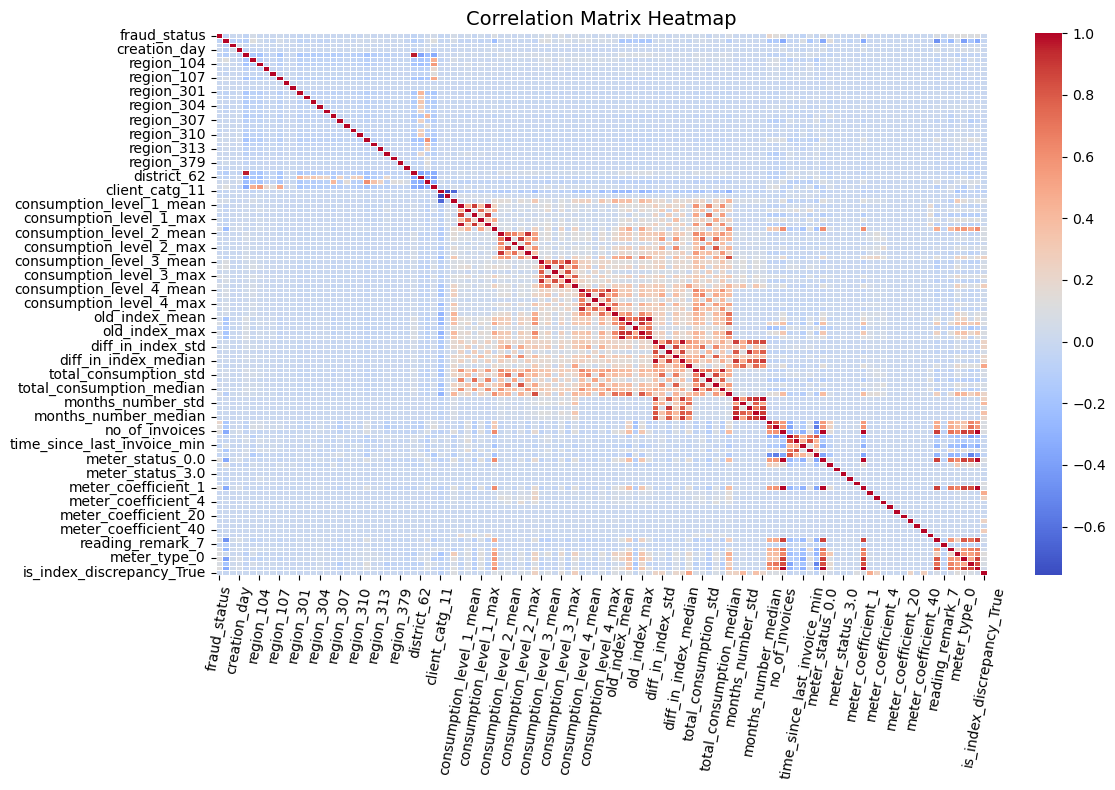

In [9]:
corr_pearson = final_dataset.drop(['client_id', 'creation_date'], axis = 1).corr(method='pearson')

plt.figure(figsize=(12, 8))  # Adjust the figure size if needed

# Create the heatmap
heatmap = sns.heatmap(
    corr_pearson,
    annot=False,  # Show correlation values
    # fmt=".2f",   # Format the correlation values to 2 decimal places
    cmap="coolwarm",  # Color scheme
    linewidths=0.5,  # Add lines between cells
    cbar=True  # Show the color bar
)

# Add title and adjust label font sizes
plt.title('Correlation Matrix Heatmap', fontsize=14)
plt.xticks(fontsize=10, rotation=80)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()  # Automatically adjust layout to prevent overlap

plt.show()

Based on the correlation heatmap and printed statements of what pairs of features are correlated with one another, we identify many different pairs of features with correlation greater than 0.90.

In [10]:
# Find pairs of features with correlation greater than 0.90
correlated_features = set()  # Initialize an empty set

# Iterate over the columns
for col in corr_pearson.columns:
    # Find correlated features
    corr_features = corr_pearson.index[(corr_pearson[col] > 0.90) | (corr_pearson[col] < -0.90)].tolist()
    
    # Update the set
    for corr_feature in corr_features:
        if corr_feature != col:
            correlated_features.add((col, corr_feature, corr_pearson.loc[col, corr_feature]))

# Display the correlated feature pairs with their correlation values
print("Correlated Feature Pairs with Correlation Values:")
for pair in correlated_features:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Correlated Feature Pairs with Correlation Values:
consumption_level_1_median and consumption_level_1_mean: 0.97
months_number_max and months_number_mean: 0.92
months_number_mean and months_number_median: 0.99
consumption_level_3_max and consumption_level_3_std: 0.90
no_of_invoices and meter_coefficient_1: 1.00
old_index_mean and old_index_max: 0.92
meter_status_0.0 and is_index_discrepancy_False: 1.00
consumption_level_3_std and consumption_level_3_max: 0.90
consumption_level_4_mean and consumption_level_4_median: 0.91
meter_coefficient_1 and meter_status_0.0: 1.00
consumption_level_1_min and consumption_level_1_median: 0.91
old_index_mean and old_index_median: 0.97
consumption_level_1_median and consumption_level_1_min: 0.91
diff_in_index_median and diff_in_index_mean: 0.97
months_number_min and diff_in_index_min: 0.91
region_101 and district_60: 0.96
consumption_level_2_median and consumption_level_2_mean: 0.91
no_of_invoices and is_index_discrepancy_False: 1.00
consumption_level_2_m

We then select a set of features to drop from the dataset. These features are selected on the basis that remaining features are more broad in terms of their meanings, with a possibility of being an indicator of fraud much more than the other.

In [11]:
features_to_drop = [
    "months_number_std", "consumption_level_3_std", "old_index_std", "meter_coefficient_1",
    "consumption_level_1_median", "consumption_level_3_median", "district_60", "meter_status_0.0",
    "months_number_mean", "total_consumption_median", "diff_in_index_median", "consumption_level_4_std"
]

# Drop the features
final_dataset = final_dataset.drop(columns=features_to_drop, errors="ignore")

print(f"Filtered features: {final_dataset.columns.tolist()}")

Filtered features: ['client_id', 'creation_date', 'fraud_status', 'creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_106', 'region_107', 'region_199', 'region_206', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_308', 'region_309', 'region_310', 'region_311', 'region_312', 'region_313', 'region_371', 'region_372', 'region_379', 'region_399', 'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12', 'client_catg_51', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_min', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_std', 'consumption_level_2_min', 'consumption_level_2_max', 'consumption_level_2_median', 'consumption_level_2_sum', 'consumption_level_3_mean', 'consumption_level_3_min', 'consumption_level_3_max', 'consumption_level_3_sum', 'consumption_level_4_me

In [12]:
# Increase the display width
pd.set_option('display.width', 1000)

# Increase the max number of columns displayed
pd.set_option('max_info_columns', 200)

# Check the info
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 105 columns):
 #    Column                          Non-Null Count   Dtype         
---   ------                          --------------   -----         
 0    client_id                       135493 non-null  object        
 1    creation_date                   135493 non-null  datetime64[ns]
 2    fraud_status                    135493 non-null  float64       
 3    creation_year                   135493 non-null  int32         
 4    creation_month                  135493 non-null  int32         
 5    creation_day                    135493 non-null  int32         
 6    region_101                      135493 non-null  int64         
 7    region_103                      135493 non-null  int64         
 8    region_104                      135493 non-null  int64         
 9    region_105                      135493 non-null  int64         
 10   region_106                      135493 non

# Train Test Split

As the provided test dataset did not have labels, we are unable to evaluate on it to determine the performance of our model. Hence, we create our own test set as a subset (20%) of the finalised train dataset.

In [13]:
# Split the dataset into train and test
train_set, test_set = train_test_split(final_dataset, test_size=0.2, random_state=42)

print(train_set.shape)
print(test_set.shape)

(108394, 105)
(27099, 105)


We save these datasets and store all of them separately in a folder called transformed_data.

In [14]:
# Save the final datasets
final_dataset.to_csv("./transformed_data/final_dataset.csv", index=False)
train_set.to_csv("./transformed_data/train_set.csv", index=False)
test_set.to_csv("./transformed_data/test_set.csv", index=False)

# Resampling [SMOTE]

To handle the class inbalances identified in our dataset, we perform SMOTE to remove these imbalances. As SMOTE synthesizes data using interpolation of features of the minority class, we will need to remove `client_id` ad `creation_date`, since these are unique identifiers for clients. Leaving them in will just create duplicate clients within the dataset.

In [15]:
# Split the train_data into features and target
X = train_set.drop(['client_id', 'creation_date','fraud_status'], axis=1)
y = train_set['fraud_status']

An additional consideration we had in performing SMOTE, was the possibility of cross-validation during our model building process. Cross validation should be done with training on SMOTEd data, and evaluating on non-smoted validation data, for the following reasons:

- prevent data leakage: performing SMOTE on both together could introduce patterns into the validation set that overlap with the training set.
- model after real-world scenario: fraud class will always be a minority in the real world, and evaluating on non-SMOTEd validation data ensures that the model's performance metrics are realistic and reflective of how it will perform on unseen, non-augmented data.


In [16]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

for i, (_, fold_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}: ")

    X_fold = X.iloc[fold_index]
    y_fold = y.iloc[fold_index]

    print(f"length of fold set: {len(X_fold)}")
    print(f"Percentage of fraud cases in train set: {y_fold.sum()/len(y)}")

    # Apply SMOTE
    X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold, y_fold)

    # Check the number of fraud cases after resampling
    print(f"Percentage of fraud cases in resampled fold set: {y_fold_resampled.sum()/len(y_fold_resampled)}")
    print(f"New length of fold set: {len(X_fold_resampled)}")

    # Combine fold data
    fold_data = pd.concat([X_fold, y_fold], axis=1)
    
    # Combine smote_fold data
    smote_fold_data = pd.concat([X_fold_resampled, y_fold_resampled], axis=1)

    # Save the data
    fold_data.to_csv(f"./smote_train_data/fold_{i+1}.csv", index=False)
    print("Validation data saved successfully!")
    smote_fold_data.to_csv(f"./smote_train_data/smote_fold_{i+1}.csv", index=False)
    print("Resampled train data saved successfully!")

    print("\n")

Fold 1: 
length of fold set: 21679
Percentage of fraud cases in train set: 0.011070723471778881
Percentage of fraud cases in resampled fold set: 0.5
New length of fold set: 40958
Validation data saved successfully!
Resampled train data saved successfully!


Fold 2: 
length of fold set: 21679
Percentage of fraud cases in train set: 0.011070723471778881
Percentage of fraud cases in resampled fold set: 0.5
New length of fold set: 40958
Validation data saved successfully!
Resampled train data saved successfully!


Fold 3: 
length of fold set: 21679
Percentage of fraud cases in train set: 0.01107994907467203
Percentage of fraud cases in resampled fold set: 0.5
New length of fold set: 40956
Validation data saved successfully!
Resampled train data saved successfully!


Fold 4: 
length of fold set: 21679
Percentage of fraud cases in train set: 0.01107994907467203
Percentage of fraud cases in resampled fold set: 0.5
New length of fold set: 40956
Validation data saved successfully!
Resampled tra